#DATA WRAGLING

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'jayeshx19/morning-routine-dataset'

Dataset URL: https://www.kaggle.com/datasets/jayeshx19/morning-routine-dataset
License(s): MIT
  0% 0.00/26.3k [00:00<?, ?B/s]
100% 26.3k/26.3k [00:00<00:00, 64.0MB/s]


#IMPORT LIBRARY

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import joblib
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample, shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#ACCES DATA

In [ ]:
target_file= '/content/morning-routine-dataset.zip'
extracting= zipfile.ZipFile(target_file, 'r')
extracting.extractall('/content/morning_dataset')
extracting.close()

In [ ]:
df= pd.read_csv('/content/morning_dataset/Morning_Routine_Productivity_Dataset.csv')
df.head()

,Date,Wake-up Time,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Breakfast Type,Journaling (Y/N),Work Start Time,Productivity Score (1-10),Mood,Notes
0,2023-02-01 10:21:52.870632,5:30 AM,6.6,20,60,Protein-rich,Yes,6:30 AM,6,Neutral,Collection whole decision middle.
1,2023-02-02 10:21:52.870632,8:15 AM,8.0,5,50,Heavy,No,11:15 AM,7,Happy,Tree player behavior various up such attention...
2,2023-02-03 10:21:52.870632,8:30 AM,8.9,25,30,Carb-rich,Yes,10:30 AM,10,Happy,If hard focus nor trip forward change per.
3,2023-02-04 10:21:52.870632,5:00 AM,8.4,25,30,Skipped,Yes,7:00 AM,7,Happy,Physical threat federal with thing.
4,2023-02-05 10:21:52.870632,5:15 AM,8.2,25,30,Heavy,No,6:15 AM,10,Happy,Ground class Mr future.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       900 non-null    object 
 1   Wake-up Time               900 non-null    object 
 2   Sleep Duration (hrs)       900 non-null    float64
 3   Meditation (mins)          900 non-null    int64  
 4   Exercise (mins)            900 non-null    int64  
 5   Breakfast Type             900 non-null    object 
 6   Journaling (Y/N)           900 non-null    object 
 7   Work Start Time            900 non-null    object 
 8   Productivity Score (1-10)  900 non-null    int64  
 9   Mood                       900 non-null    object 
 10  Notes                      900 non-null    object 
dtypes: float64(1), int64(3), object(7)
memory usage: 77.5+ KB


In [ ]:
df.describe()

,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Productivity Score (1-10)
count,900.000000,900.000000,900.000000,900.000000
mean,6.978444,14.711111,29.733333,5.811111
std,1.149872,9.937227,20.622568,2.157814
min,5.000000,0.000000,0.000000,1.000000
25%,5.900000,5.000000,10.000000,4.000000
50%,7.000000,15.000000,30.000000,6.000000
75%,8.000000,25.000000,50.000000,7.000000
max,9.000000,30.000000,60.000000,10.000000


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.isnull().sum()

,0
Date,0
Wake-up Time,0
Sleep Duration (hrs),0
Meditation (mins),0
Exercise (mins),0
Breakfast Type,0
Journaling (Y/N),0
Work Start Time,0
Productivity Score (1-10),0
Mood,0


In [ ]:
df['Date']= pd.to_datetime(df['Date'])

In [ ]:
def time_to_minute(time_konv):
  if pd.isna(time_konv):
    return np.nan
  try:
    time_obj = pd.to_datetime(time_konv, format='%I:%M %p').time()
    return time_obj.hour * 60 + time_obj.minute
  except:
    return np.nan

In [ ]:
df['Wake-up Time']= df['Wake-up Time'].apply(time_to_minute)
df['Work Start Time']= df['Work Start Time'].apply(time_to_minute)

In [ ]:
df.head()

,Date,Wake-up Time,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Breakfast Type,Journaling (Y/N),Work Start Time,Productivity Score (1-10),Mood,Notes
0,2023-02-01 10:21:52.870632,330,6.6,20,60,Protein-rich,Yes,390,6,Neutral,Collection whole decision middle.
1,2023-02-02 10:21:52.870632,495,8.0,5,50,Heavy,No,675,7,Happy,Tree player behavior various up such attention...
2,2023-02-03 10:21:52.870632,510,8.9,25,30,Carb-rich,Yes,630,10,Happy,If hard focus nor trip forward change per.
3,2023-02-04 10:21:52.870632,300,8.4,25,30,Skipped,Yes,420,7,Happy,Physical threat federal with thing.
4,2023-02-05 10:21:52.870632,315,8.2,25,30,Heavy,No,375,10,Happy,Ground class Mr future.


In [ ]:
df= df.drop('Notes', axis=1)

#EDA

In [ ]:
numerical= df.select_dtypes(include=[np.number]).columns.tolist()
categorical= df.select_dtypes(include='object').columns.tolist()

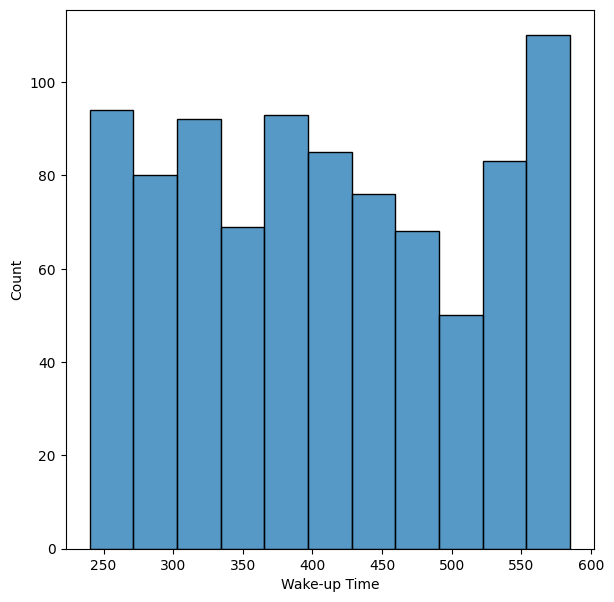

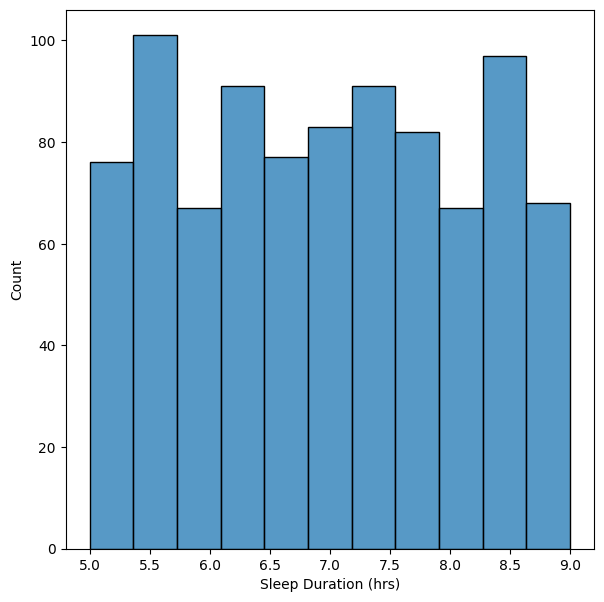

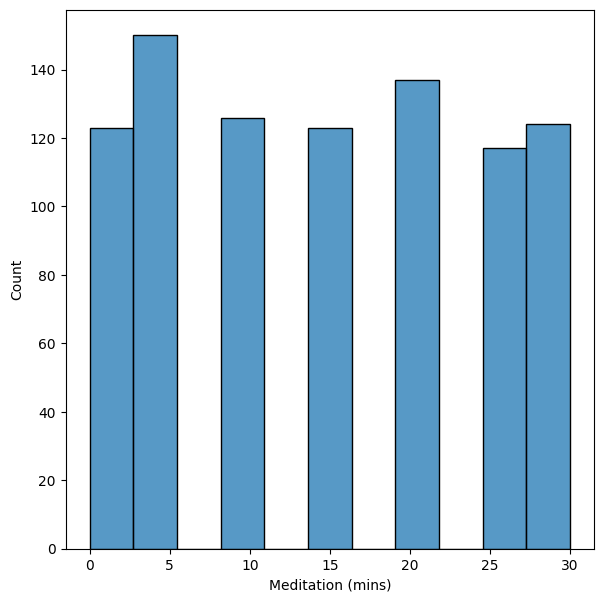

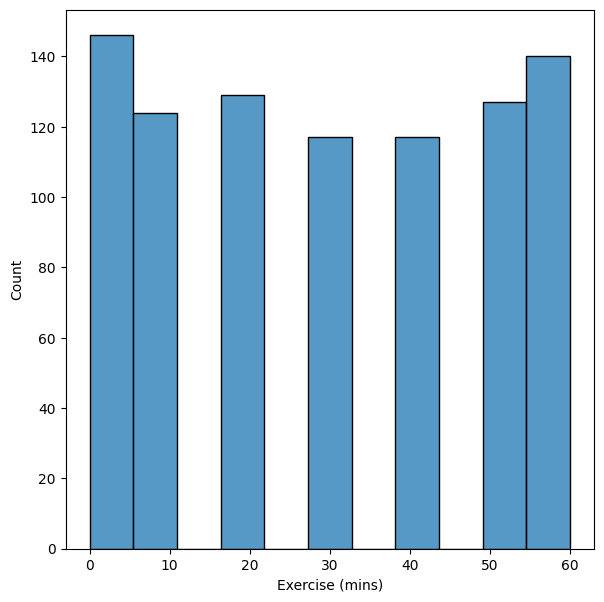

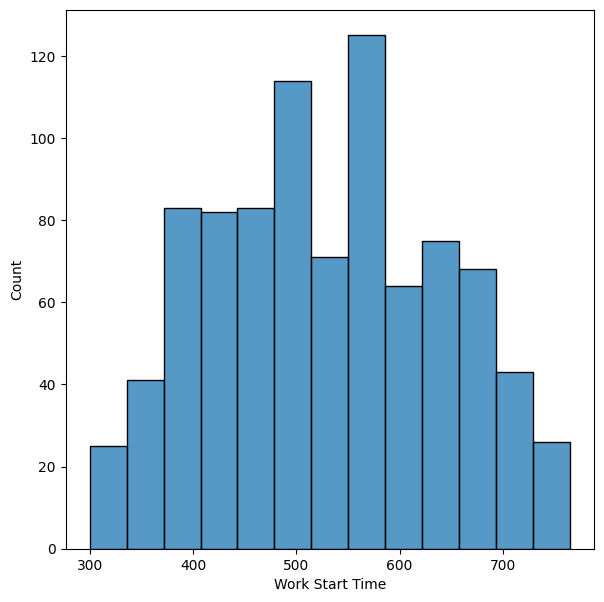

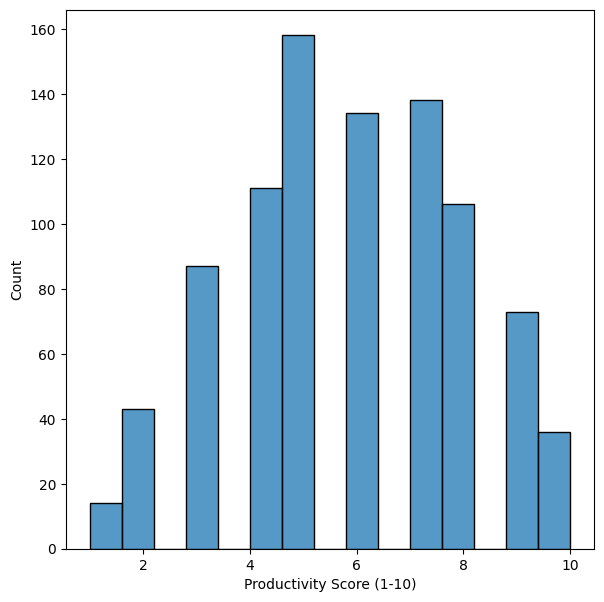

In [ ]:
for i, col in enumerate(numerical):
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  sns.histplot(df[col])
  plt.show()

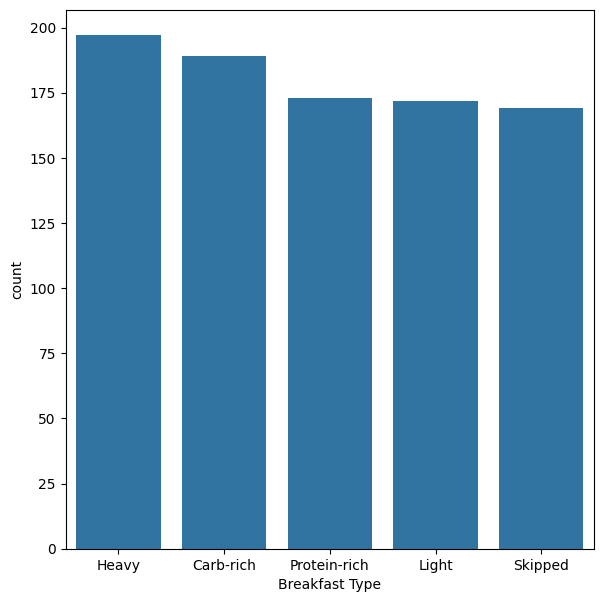

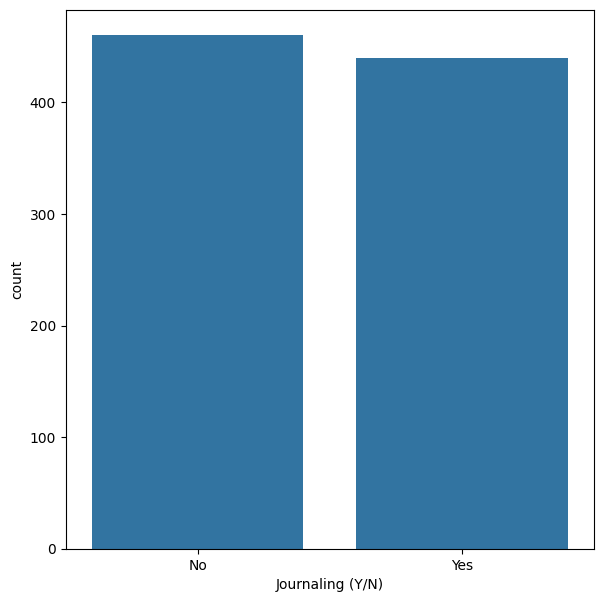

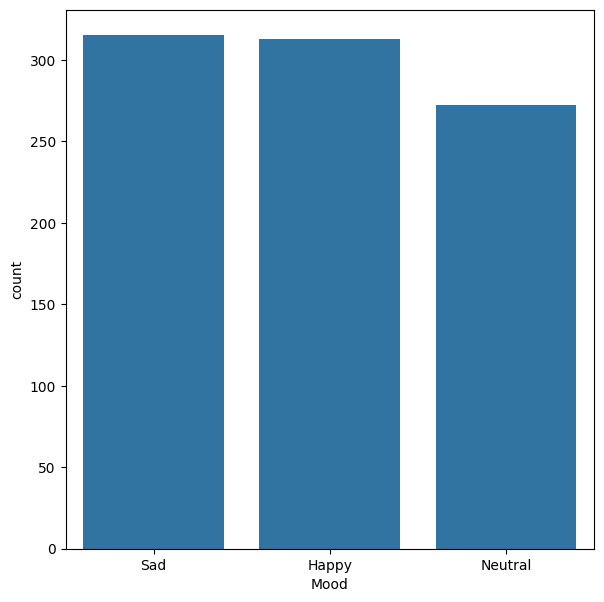

In [ ]:
for i, col in enumerate(categorical):
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  sns.barplot(df[col].value_counts().reset_index(), x=col, y='count')
  plt.show()

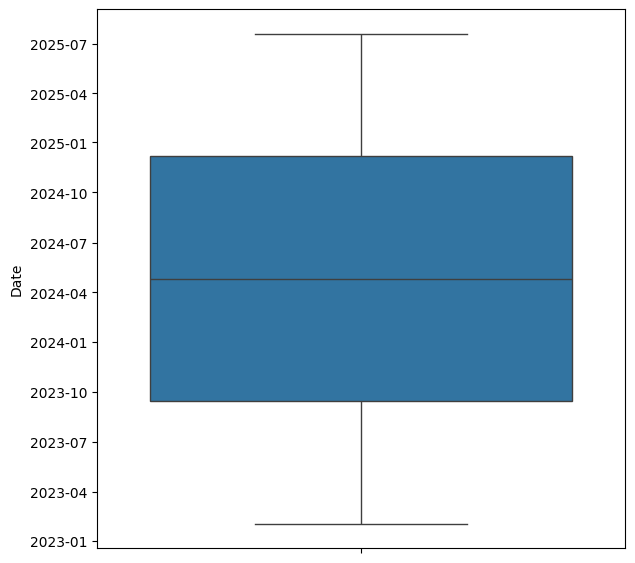

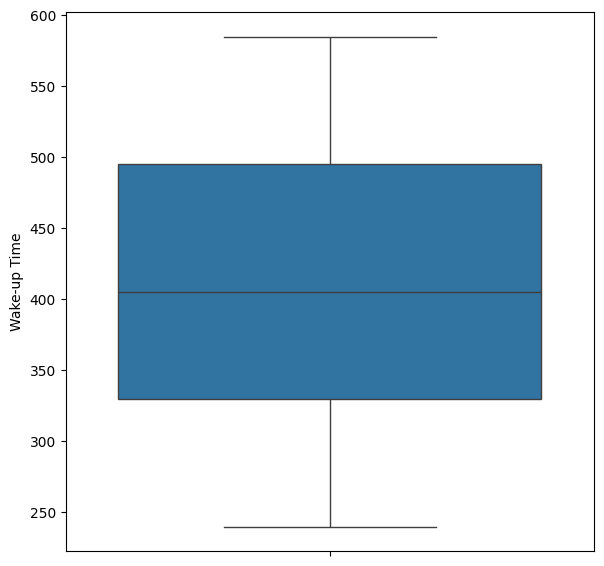

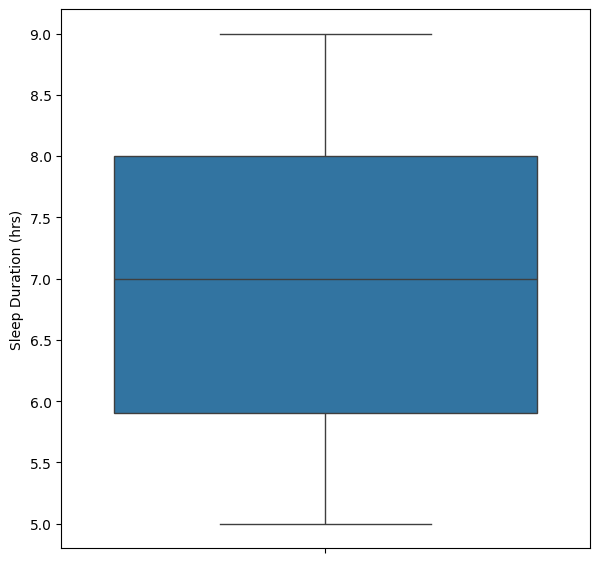

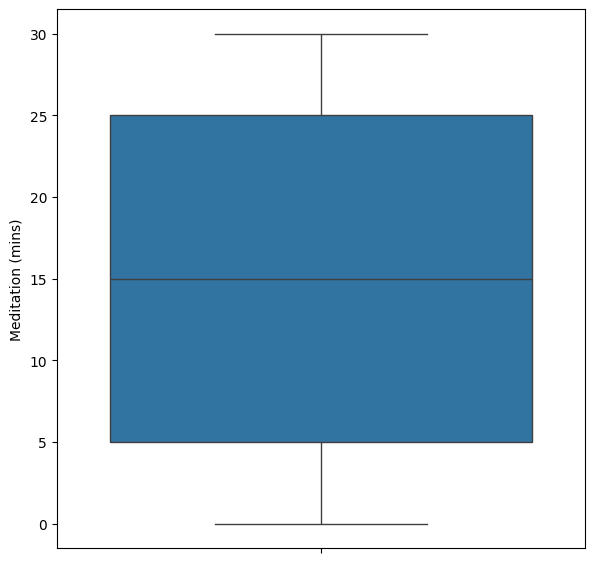

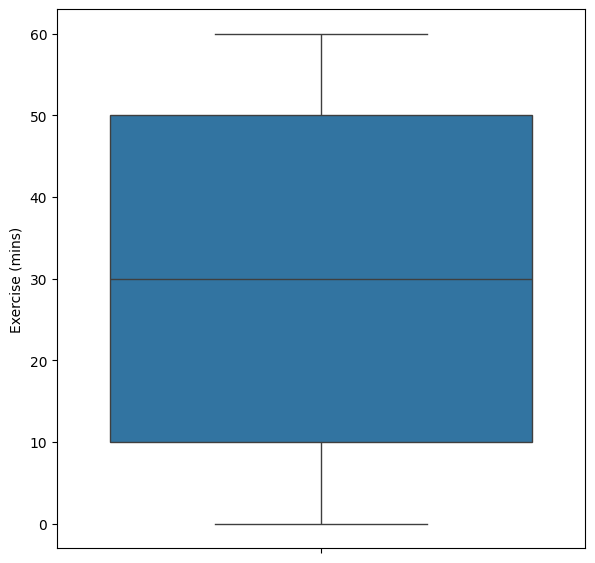

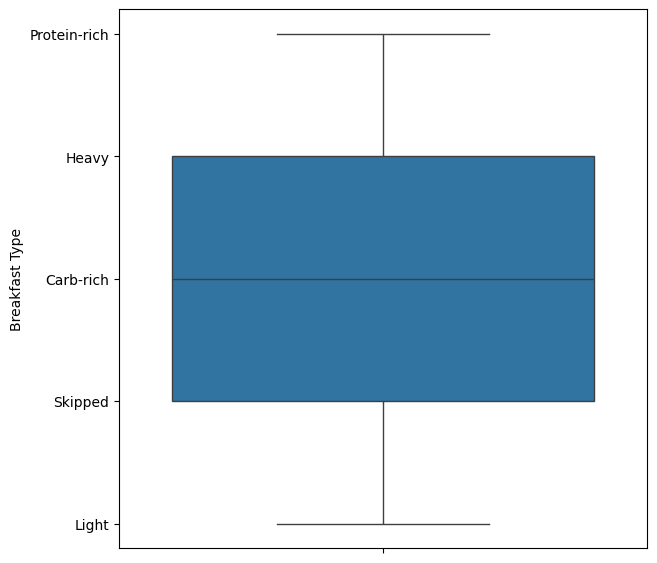

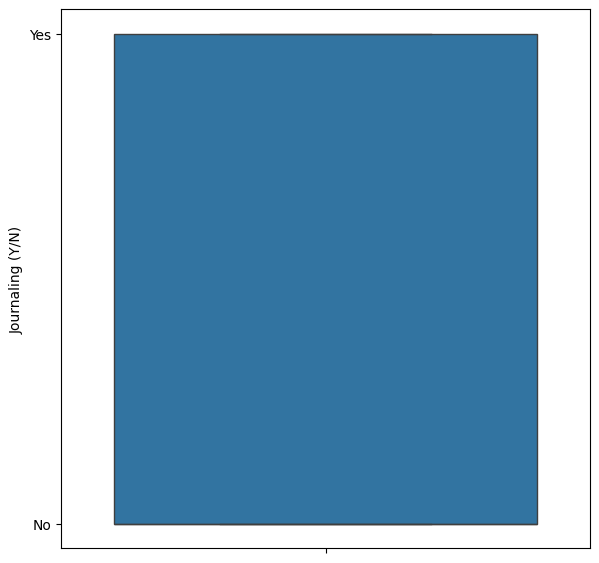

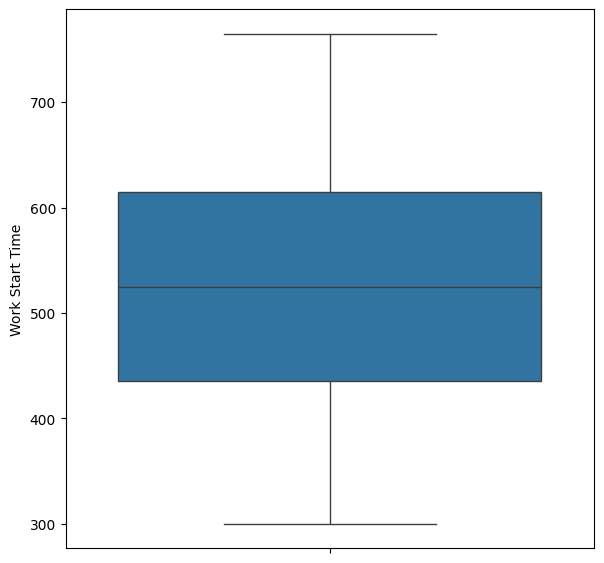

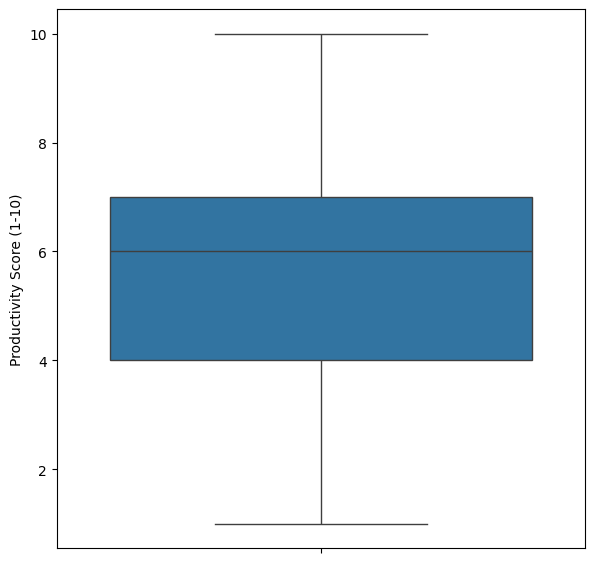

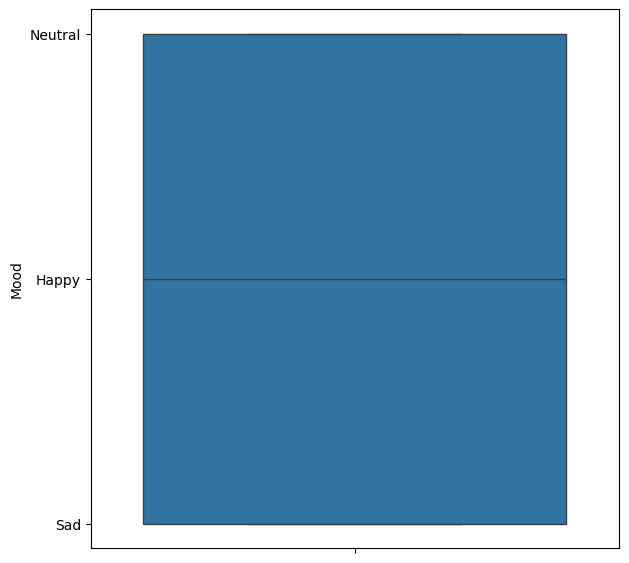

In [ ]:
for i, col in enumerate(df.columns):
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  sns.boxplot(df[col])
  plt.show()

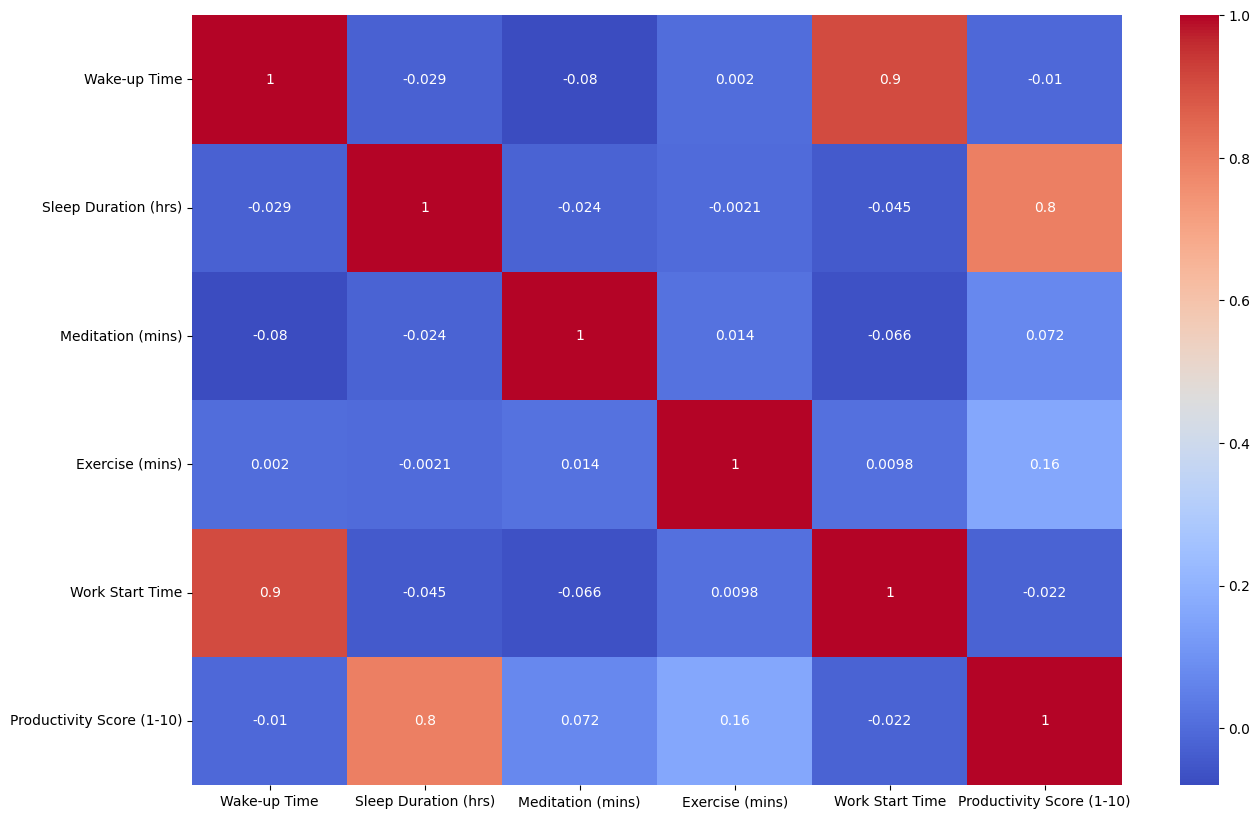

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

#FEATURE ENGINEERING

In [ ]:
df_new = df.copy()
df_new['prep_time']= df_new['Work Start Time'] - df_new['Wake-up Time']

In [ ]:
df_new= df_new.drop('Work Start Time', axis=1)

In [ ]:
df_new.head()

,Date,Wake-up Time,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Breakfast Type,Journaling (Y/N),Productivity Score (1-10),Mood,prep_time
0,2023-02-01 10:21:52.870632,330,6.6,20,60,Protein-rich,Yes,6,Neutral,60
1,2023-02-02 10:21:52.870632,495,8.0,5,50,Heavy,No,7,Happy,180
2,2023-02-03 10:21:52.870632,510,8.9,25,30,Carb-rich,Yes,10,Happy,120
3,2023-02-04 10:21:52.870632,300,8.4,25,30,Skipped,Yes,7,Happy,120
4,2023-02-05 10:21:52.870632,315,8.2,25,30,Heavy,No,10,Happy,60


In [ ]:
mood_mapping = {
    'Sad' : 0,
    'Neutral' : 1,
    'Happy' : 2
}

breakfast_mapping = {
    'Skipped' : 0,
    'Light' : 1,
    'Protein-rich' :2,
    'Carb-rich': 3,
    'Heavy' : 4
}

journaling_mapping= {
    'No' :0,
    'Yes' : 1
}

In [ ]:
df_new['Breakfast Type']= df_new['Breakfast Type'].map(breakfast_mapping)
df_new['Journaling (Y/N)']= df_new['Journaling (Y/N)'].map(journaling_mapping)
df_new['Mood']= df_new['Mood'].map(mood_mapping)

In [ ]:
df_new.rename(columns={'Productivity Score (1-10)' : 'Activity Score', 'Journaling (Y/N)' : 'Journaling'}, inplace=True)

In [ ]:
df_new.head()

,Date,Wake-up Time,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Breakfast Type,Journaling,Activity Score,Mood,prep_time
0,2023-02-01 10:21:52.870632,330,6.6,20,60,2,1,6,1,60
1,2023-02-02 10:21:52.870632,495,8.0,5,50,4,0,7,2,180
2,2023-02-03 10:21:52.870632,510,8.9,25,30,3,1,10,2,120
3,2023-02-04 10:21:52.870632,300,8.4,25,30,0,1,7,2,120
4,2023-02-05 10:21:52.870632,315,8.2,25,30,4,0,10,2,60


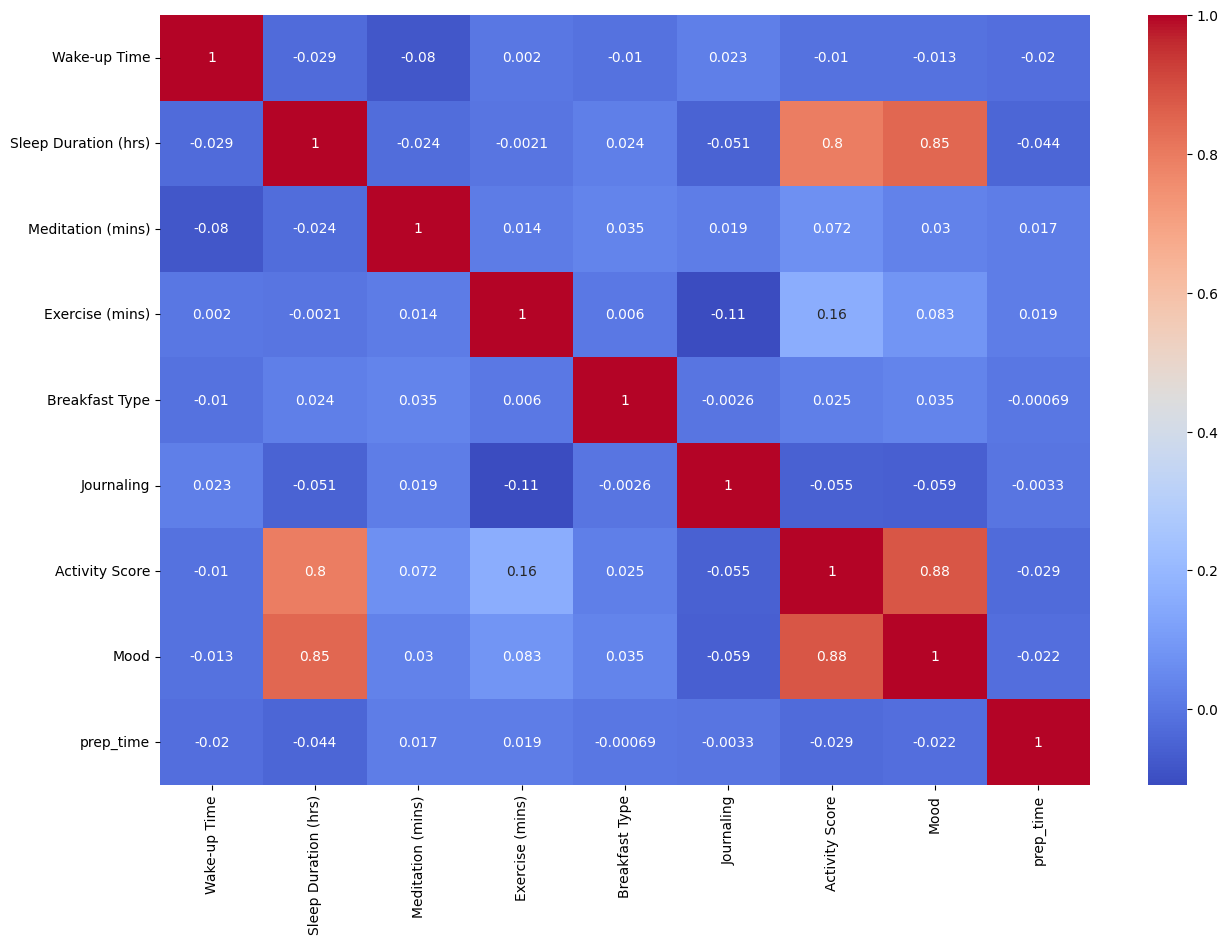

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df_new.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
df_neutral = df_new[(df_new.Mood==1)].copy()
df_train = df_new[(df_new.Mood != 1)].copy()

In [ ]:
df_train.head()

,Date,Wake-up Time,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Breakfast Type,Journaling,Activity Score,Mood,prep_time
1,2023-02-02 10:21:52.870632,495,8.0,5,50,4,0,7,2,180
2,2023-02-03 10:21:52.870632,510,8.9,25,30,3,1,10,2,120
3,2023-02-04 10:21:52.870632,300,8.4,25,30,0,1,7,2,120
4,2023-02-05 10:21:52.870632,315,8.2,25,30,4,0,10,2,60
6,2023-02-07 10:21:52.870632,270,8.8,5,0,0,0,10,2,120


In [ ]:
train_df, test_df= train_test_split(df_train, test_size=0.3, random_state=42)

print("Shape from train_df : ", train_df.shape)
print("Shape from test_df : ", test_df.shape)

Shape from train_df :  (439, 10)
Shape from test_df :  (189, 10)


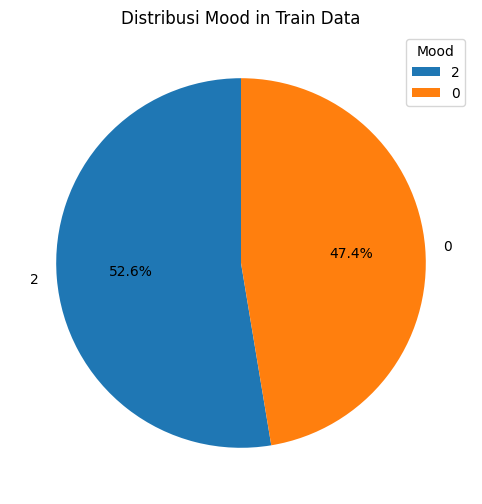

In [ ]:
values= train_df['Mood'].value_counts()

plt.figure(figsize=(10,6))
plt.pie(values, labels=values.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Mood in Train Data')
plt.legend(title='Mood', labels=values.index, loc='upper right')
plt.show()

In [ ]:
train_df['Mood'].value_counts()

,count
Mood,
2,231
0,208


In [ ]:
df_majority= train_df[(train_df.Mood == 2)]
df_minority= train_df[(train_df.Mood == 0)]

In [ ]:
df_major_undersample= resample(df_majority, n_samples=len(df_minority), random_state=42)
df_undersample_train= pd.concat([df_major_undersample, df_minority]).reset_index(drop=True)
df_undersample_train= shuffle(df_undersample_train, random_state=42)
df_undersample_train.reset_index(drop=True, inplace= True)
df_undersample_train.head()

,Date,Wake-up Time,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Breakfast Type,Journaling,Activity Score,Mood,prep_time
0,2024-09-01 10:21:52.870632,375,8.8,30,30,2,1,9,2,180
1,2024-02-09 10:21:52.870632,360,5.2,5,40,3,0,6,0,180
2,2025-01-13 10:21:52.870632,285,5.6,30,40,0,1,6,0,120
3,2024-07-18 10:21:52.870632,330,8.7,10,10,2,0,7,2,60
4,2023-09-18 10:21:52.870632,495,8.0,15,40,3,1,8,2,60


In [ ]:
X_train= df_undersample_train.drop(['Date', 'Mood', 'Activity Score'], axis=1)
y_train= df_undersample_train['Mood']

X_test= test_df.drop(['Date', 'Mood', 'Activity Score'], axis=1)
y_test= test_df['Mood']

In [ ]:
scaler= MinMaxScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

In [ ]:
joblib.dump(scaler, '/content/joblib_model/scaler.joblib')

['/content/joblib_model/scaler.joblib']

In [ ]:
X_train_scaled_df= pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df= pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
X_train_scaled_df.head()

,Wake-up Time,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Breakfast Type,Journaling,prep_time
0,0.391304,0.950,1.000000,0.500000,0.50,1.0,1.0
1,0.347826,0.050,0.166667,0.666667,0.75,0.0,1.0
2,0.130435,0.150,1.000000,0.666667,0.00,1.0,0.5
3,0.260870,0.925,0.333333,0.166667,0.50,0.0,0.0
4,0.739130,0.750,0.500000,0.666667,0.75,1.0,0.0


#Modelling

In [ ]:
DT= DecisionTreeClassifier(random_state=42)

params_grid_dt= {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [100,200,300],
    'min_samples_split' : [1,2,3],
    'min_samples_leaf' : [1,2,3],
    'max_features' : ['sqrt', 'log2']
}
tree_model= GridSearchCV(DT, param_grid=params_grid_dt, cv=5, n_jobs=1)
tree_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/util

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [100, 200, 300],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3]})

In [ ]:
print(f'Best score : {tree_model.best_score_}')
print(f'Best params : {tree_model.best_params_}')

Best score : 0.9640275387263341
Best params : {'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
DT_model= DecisionTreeClassifier(criterion='entropy', max_depth=100,  max_features='sqrt', min_samples_leaf=1, min_samples_split=2, random_state=42)
DT_model = DT_model.fit(X_train_scaled, y_train)
joblib.dump(DT_model, '/content/joblib_model/DT_model.joblib')

['/content/joblib_model/DT_model.joblib']

Confusion Matrix Model Decision Tree Classifier :
 [[101   6]
 [  7  75]]
Classification Report Model Decision Tree Classifier :
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       107
           2       0.93      0.91      0.92        82

    accuracy                           0.93       189
   macro avg       0.93      0.93      0.93       189
weighted avg       0.93      0.93      0.93       189

Accuracy Score Model Decision Tree Classifier : 0.9312169312169312


Text(0.5, 25.722222222222214, 'Predicted')

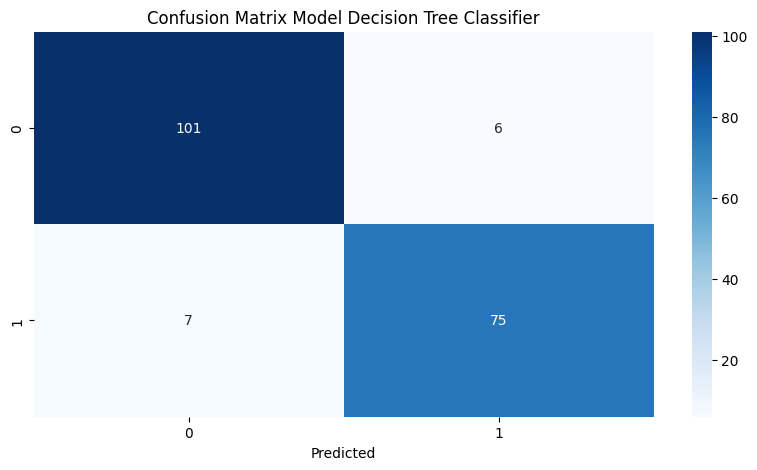

In [ ]:
y_pred_test= tree_model.predict(X_test_scaled)

cm= confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix Model Decision Tree Classifier :\n", cm)

cr= classification_report(y_test, y_pred_test)
print("Classification Report Model Decision Tree Classifier :\n", cr)

acc= accuracy_score(y_test, y_pred_test)
print("Accuracy Score Model Decision Tree Classifier :", acc)

plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Model Decision Tree Classifier')
plt.xlabel('Predicted')

#Testing Model

In [ ]:
df_neutral.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, 0 to 899
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  272 non-null    datetime64[ns]
 1   Wake-up Time          272 non-null    int64         
 2   Sleep Duration (hrs)  272 non-null    float64       
 3   Meditation (mins)     272 non-null    int64         
 4   Exercise (mins)       272 non-null    int64         
 5   Breakfast Type        272 non-null    int64         
 6   Journaling            272 non-null    int64         
 7   Activity Score        272 non-null    int64         
 8   Mood                  272 non-null    int64         
 9   prep_time             272 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 23.4 KB


In [ ]:
X_neutral= df_neutral.drop(['Date', 'Mood', 'Activity Score'], axis=1)
X_neutral.head()

,Wake-up Time,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Breakfast Type,Journaling,prep_time
0,330,6.6,20,60,2,1,60
5,435,8.2,15,10,0,0,60
8,465,7.0,5,10,4,1,60
10,255,7.5,0,50,4,1,180
14,525,7.0,5,0,4,1,60


In [ ]:
for features in X_neutral.columns:
  scaler= joblib.load('/content/joblib_model/scaler.joblib')
  X_neutral_scaled= scaler.transform(X_neutral)

In [ ]:
model_load= joblib.load('/content/joblib_model/DT_model.joblib')
y_pred_neutral= model_load.predict(X_neutral_scaled)
df_neutral['predict_model']= y_pred_neutral
df_neutral.head()

,Date,Wake-up Time,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Breakfast Type,Journaling,Activity Score,Mood,prep_time,predict_model
0,2023-02-01 10:21:52.870632,330,6.6,20,60,2,1,6,1,60,0
5,2023-02-06 10:21:52.870632,435,8.2,15,10,0,0,6,1,60,2
8,2023-02-09 10:21:52.870632,465,7.0,5,10,4,1,5,1,60,0
10,2023-02-11 10:21:52.870632,255,7.5,0,50,4,1,6,1,180,2
14,2023-02-15 10:21:52.870632,525,7.0,5,0,4,1,6,1,60,0


In [ ]:
df_train.head()

,Date,Wake-up Time,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Breakfast Type,Journaling,Activity Score,Mood,prep_time
1,2023-02-02 10:21:52.870632,495,8.0,5,50,4,0,7,2,180
2,2023-02-03 10:21:52.870632,510,8.9,25,30,3,1,10,2,120
3,2023-02-04 10:21:52.870632,300,8.4,25,30,0,1,7,2,120
4,2023-02-05 10:21:52.870632,315,8.2,25,30,4,0,10,2,60
6,2023-02-07 10:21:52.870632,270,8.8,5,0,0,0,10,2,120


In [ ]:
with open('predict_mood_by_morning_routine.pkl', 'wb') as model_file:
    pickle.dump(DT_model, model_file)

In [ ]:
final_df= pd.concat([df_train, df_neutral])
final_df.head()

,Date,Wake-up Time,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Breakfast Type,Journaling,Activity Score,Mood,prep_time,predict_model
1,2023-02-02 10:21:52.870632,495,8.0,5,50,4,0,7,2,180,NaN
2,2023-02-03 10:21:52.870632,510,8.9,25,30,3,1,10,2,120,NaN
3,2023-02-04 10:21:52.870632,300,8.4,25,30,0,1,7,2,120,NaN
4,2023-02-05 10:21:52.870632,315,8.2,25,30,4,0,10,2,60,NaN
6,2023-02-07 10:21:52.870632,270,8.8,5,0,0,0,10,2,120,NaN


In [ ]:
final_df.to_csv('mood_predict.csv', index=False)

In [ ]:
df_neutral = df_neutral.drop('Mood', axis=1)

In [ ]:
df_neutral.head()

,Date,Wake-up Time,Sleep Duration (hrs),Meditation (mins),Exercise (mins),Breakfast Type,Journaling,Activity Score,prep_time,predict_model
0,2023-02-01 10:21:52.870632,330,6.6,20,60,2,1,6,60,0
5,2023-02-06 10:21:52.870632,435,8.2,15,10,0,0,6,60,2
8,2023-02-09 10:21:52.870632,465,7.0,5,10,4,1,5,60,0
10,2023-02-11 10:21:52.870632,255,7.5,0,50,4,1,6,180,2
14,2023-02-15 10:21:52.870632,525,7.0,5,0,4,1,6,60,0


In [ ]:
df_neutral.to_csv('df_predict.csv', index=False)